# Basic NPL Analysis for Bolsonaro Twitter
This code primarily pass over three phases, ending up with the fourth phase where I share some perspectives:

1: **Pre-processing (More difficulty)**

2: **Analysis**

3: **Results**

4: **Notes**


## PHASE 1: PRE-PROCESSING
That is my first job doing NPL analysis and I think that this phase is the more important at all. Considering the **Pareto's Law**, over of 80% of your work will be here. Must because the cleaning part is quite difficulty and treacherous. The Library most used here for pre-processing and analysis is **quanteda** there I really recommend!

In [1]:
##### LIBRARY
library(quanteda)
library(stopwords)
library(wordcloud2)
library(tidytext)
library(tidyverse)
library(lexiconPT)
library(Matrix)
library(irlba)
library(tm)
library(SnowballC)
library(dplyr)

##### OPTIONS
quanteda_options("threads" = 3)
set.seed(651)

Package version: 1.4.3
Parallel computing: 2 of 4 threads used.
See https://quanteda.io for tutorials and examples.

Attaching package: ‘quanteda’

The following object is masked from ‘jupyter:irkernel’:

    View

The following object is masked from ‘package:utils’:

    View

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0.9000     ✔ purrr   0.3.2     
✔ tibble  2.1.3          ✔ dplyr   0.8.3     
✔ tidyr   0.8.3          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: NLP

Attaching package: ‘NLP’

The following object is masked from ‘package:ggplot2’:

    annotate

The following object is masked from ‘package:httr’:

    content


Attachin

### IMPORTING DATASETS AND DEFINING SOME USEFUL VARIABLES

In [2]:
# BOLSONARO DATASET
db <- read.csv('../input/jair-bolsonaro-twitter-data/bolsonaro_tweets.csv', sep = ',', encoding="UTF-8")
db$link <- NULL
db$likes <- NULL
db$retweets <- NULL

# LEMMATIZATION DICTIONARY
ld <- read.csv('../input/lemmatization-list-in-pt-for-npl/lemmatization-pt.txt', sep = '\t', header = T, encoding="UTF-8", stringsAsFactors = F)
colnames(ld) <- c('lemma','word')

# LEXICON PT DICTIONARY
lp <- lexiconPT::oplexicon_v3.0
colnames(lp)[1] <- "word"

# STOPWORDS AND NON-EASY-PATTERN-TO-FIND
custom_stop_words <- c(stopwords::stopwords(language = "pt", source = "stopwords-iso"),'q','d','p','ñ','c','pictwittercom','ex','x','twitter')

Is important to explain some topics:
1. **Lemmatization dictionary** is used in a Lemmatization process (convert a word in yours base form. For example, the words loved, loving and love will be transform in the word love as they mean the same, but in different conjugation). Every language has a dictionary.
2. **Lexicon Dictionary** will be used latter in sentiment analysis. Created manually (not by me), it's put a sentiment for a word as example: sad would get a number to define him as -1.
3. **Stopwords** Are words that doesn't increment nothing for the analysis. This choice is kind nebulous, most because there is a lot of list with more/less stopwords. As you can see, I take out some letters and terms. This decision was made after analysing the dataset and realized that contains a lot of this letters (**q** and **ñ** are slang for **que** and **não** in portuguese for example, but the others I did not figure out why they are there) and some words related to links as **twitter** and **pictwittercom**. This probably happen because the way that **quanteda** implement your function to clean.

### CLEANING THE DATA
In this step, I make the most common things in NPL Analysis to remove noise pertubations in the data. Basically I jump in functions from **tm** and **quanteda** package to figure out the best way to clean it.

In [3]:
##### PRE-PROCESSING :: CLEANING DATA 

# REMOVE EMOTICONS AND ODD CHARACTERS, BUT KEEPING ACCENTS
db$text <- sapply(db$text,function(row) iconv(row, "UTF-8", "ISO_8859-1", sub=""))

# REMOVE EMPTY ROWS THAT DOESN'T HAVE ANY TEXT BECAUSE OF THE EMOJIS
db <- db[!db$text=="", ]
rownames(db) <- 1:nrow(db)

##### QUANTEDA CLEANING PRE-PROCESSING

# CREATE A CORPUS OBJECT
mc <- quanteda::corpus(db)

# CLEANING - CREATE A TOKEN OBJECT
mct <- quanteda::tokens(x = mc, what = 'fasterword',verbose = F,
                        remove_separators = T,
                        remove_twitter = F,
                        remove_symbols = T,
                        remove_numbers = T,
                        remove_hyphens = T,
                        remove_punct = T,
                        remove_url = T)

## CLEANING - TRANSFORM TOKEN TO DATAFRAME AND TAKE OUT REMAIN PUNCTUATION (BUG FROM QUANTEDA)
# 1 - CREATE A NEW COLUMN TOKEN LENGTH
db$textQ <- NA
nt <- length(mct)

# 2 - LOOP TO GET THE TOKEN, PASTE TOGETHER & ¨PUT IN THE DATAFRAME
for(i in 1:nt){
  indexador <- paste0('text',i,collapse = '')
  db$textQ[i] <- paste0(mct[[indexador]], collapse = ' ')
}

# 3 - FUNCTION TO TAKE OUT SPECIFICs PUNCT
db$textQPF <- gsub("[][!$%()*,.:;<=>^?|~.{}]", "", db$textQ)
db$textQPF <- gsub('/', ' ', db$textQPF)
db$textQPF <- gsub('\"',' ',db$textQPF)
db$textQPF <- gsub('\'','',db$textQPF)

# 4 - REMOVE EMPTY ROWS THAT DOESN'T HAVE ANY TEXT THE PREVIOUS CLEANING (URLs most)
db <- db[!db$textQPF=="", ]
rownames(db) <- 1:nrow(db)
colnames(db) <- c('data','text_orig','text_q1','text')

# 5 - TRANSFORM INTO CORPUS AND THEN TOKEN AGAIN TO CONTINUE THE PROCESS
mc <- quanteda::corpus(db[,c('data','text')])
mct <- quanteda::tokens(x = mc, what = 'word', remove_twitter = F, remove_numbers = T)

# 6 - REMOVE AUX VARIABLES
rm(i, indexador, nt)

# CLEANING - TRANSFORM ALL LETTERS TO LOWER CASE
mct <- quanteda::tokens_tolower(x = mct)

# TRANSFORM - COMPOUND SOME EXPRESSIONS
mct <- quanteda::tokens_compound(x = mct, pattern = quanteda::phrase(c('jair bolsonaro', 'são paulo', 'sao paulo')), concatenator = ' ')

# CLEANING - TAKE OUT STOPWORDS
mct <- quanteda::tokens_remove(x = mct, pattern = custom_stop_words)

# CLEANING - LEMMATIZATION
mct <- quanteda::tokens_replace(x = mct, pattern = ld$word, replacement = ld$lemma, case_insensitive = T, valuetype = "fixed")

# CREATE A DFM OBJECT
mcd <- quanteda::dfm(x = mct)

# DFM - TAKING A MINIMUM 10 FREQUENCIES WORDS (AVOID BROKEN WORDS THAT ARE NONSENSE)
mcd <- quanteda::dfm_trim(x = mcd, min_termfreq = 10)

# CREATE A FDM OBJECT BASED IN A COMPRESS DFM OBJECT (NECESSARY - HIGH DIMENSIONALITY)
mcf <- quanteda::fcm(x = mcd) 

It is important to note that I created two objects at the end: **DFM** and **FCM**. This objects will be used to create the analysis and are well explained in [quanteda tutorial](https://tutorials.quanteda.io/basic-operations/dfm/) check out.

## PHASE 2: ANALYSIS
Here in this phase, two basic analysis was made: frequency count and similarity.
- **Frequency Count** is basically counting how many time that word appear in all dataset.
- **Similarity** Analyze basic on a specific metric (I choose cosine distance) to see how much that words are related to each other
At the end, as I have so many words in similarity matrix (think that is a matrix NxN where N is the number of words that my dataset have) and probably will have tons of words that I are not correlated/have low frequency, I will generate a sparse matrix. To further sentiment analysis, PCA was implement to reduce the dimensionalty and improve the results.

### CREATING DATAFRAMES FOR PLOTS
- **plt_frequency** is a dataframe with 2 coluns: WORD and FREQUENCY COUNT. Used for *WordCloud Plot*
- **plt_similarity** Is a matrix that contains the **similarity** between the words.

In [4]:
##### DATAFRAMES FOR PLOTS

# CREATE FOR WORD CLOUD PLOT: A DATAFRAME CONTAINS TWO COLUNS - WORD AND FREQUENCY
plt_frequency <- slam::col_sums(quanteda::convert(x = mcd, to = 'tm'))
plt_frequency <- plt_frequency[plt_frequency >= 20]
similarity_feat <- names(plt_frequency)
plt_frequency <- plt_frequency[plt_frequency >= 50]
plt_frequency <- data.frame(words = names(plt_frequency), freq = plt_frequency , row.names = NULL, stringsAsFactors = F)
colnames(plt_frequency) <- c('word','freq')

# CORRELATION SPARSE MATRIX
plt_similarity <- quanteda::textstat_simil(x = mcd, margin = "features",method = "cosine", selection = similarity_feat)
plt_similarity <- as.matrix(x = plt_similarity, diag = 1)
plt_similarity <- as(plt_similarity, "sparseMatrix")
plt_similarity <- Matrix(data = plt_similarity, sparse = T)

In [5]:
##### PCA SIMILARITY ANALYSIS

# CALCULATION
pca_analise <- irlba::prcomp_irlba(x = plt_similarity, n = 200)

# GENERATE NEW DATA
word_vectors <- pca_analise$x
rownames(word_vectors) <- rownames(plt_similarity)

# FUNCTION TO FIND HIGHER SIMILARITIES
search_synonyms <- function(word_vectors, selected_vector) {
  
  similarities <- word_vectors %*% selected_vector %>%
    tidy() %>%
    as_tibble() %>%
    rename(token = .rownames,
           similarity = unrowname.x.)
  
  similarities %>%
    arrange(-similarity)    
}

# CHOSEN WORD - BRASIL
cWord1 <- search_synonyms(word_vectors, word_vectors["brasil",])
sWord1 <- cWord1 %>% inner_join(lp, by = c("token" = "word"))

Warning message:
“'tidy.matrix' is deprecated.
See help("Deprecated")”

## PHASE 3: RESULTS

### 1 - Word Cloud

In [6]:
wordcloud2(plt_frequency, color = "random-light", size = 1, backgroundColor = "black")

HTML widgets cannot be represented in plain text (need html)

![wordcloud2](https://user-images.githubusercontent.com/32513366/63436829-caeb3600-c3ff-11e9-830e-33da0e48f134.png)
**PS**: The image for wordcloud was insert because of some issues with wordcloud2 package (unknow reason).

The wordcloud presented show that the author mentions many terms that were recurrent in his presidential campaign, well reflect his personality known in the media today and his ideological antagonism. His presidential campaign highlighted nationalist fervor, the issue of public security and a desire for change in the country's politics. 
As you see in the wordcloud, all these themes are approached with a high frequency respectively: words such as **brasil** and **brasileiro** have a more nationalistic sentiment and are the most prominent in their publications. Terms such as **violência(violence)**, **público(public)**, **polícia(police)** and **segurança(security)** reinforce the proposed debate on public security in the country, and the terms **corrupção(corruption)**, **mudança(change)**, **voto(vote)**, **eleição(election)** and **presidente(president)** show his desire for change in Brazilian politics through your presidential election. About his personality during the presidential race, Jair Messias Bolsonaro demonstrated a public image of a person based on religion, family and his military backing ground that he obtained during his career before entering politics. This personality is also reflected too, where terms such as **familia(family)**, **militar(military)**, and **deus(god)** are frequent in their posts.
Its political antagonism also appears strong, represented at the time by the more social thinking popularly defined as "a esquerda do país(the left of the country)." In Figure 1, we can see terms such as **pt** (main political party), **psol** (party also representing this ideal), **esquerdar (slang to do things from left side**), **lula** and **dilma**. The last two are the only former presidents of the country mentioned in their publications and who defended this same ideology. It is noteworthy that the frequencies of the aforementioned terms are relatively high, second only to the nationalist tenor of the presidential campaign. In addition, there is a high frequency of the term **RT** (referring to posting / copying someone's post) showing that it shares ideas from different people.

### 2 - USERS NETWORK

Registered S3 method overwritten by 'network':
  method            from    
  summary.character quanteda
Warning message:
“Use of `vertex$labelsize` is discouraged. Use `labelsize` instead.”

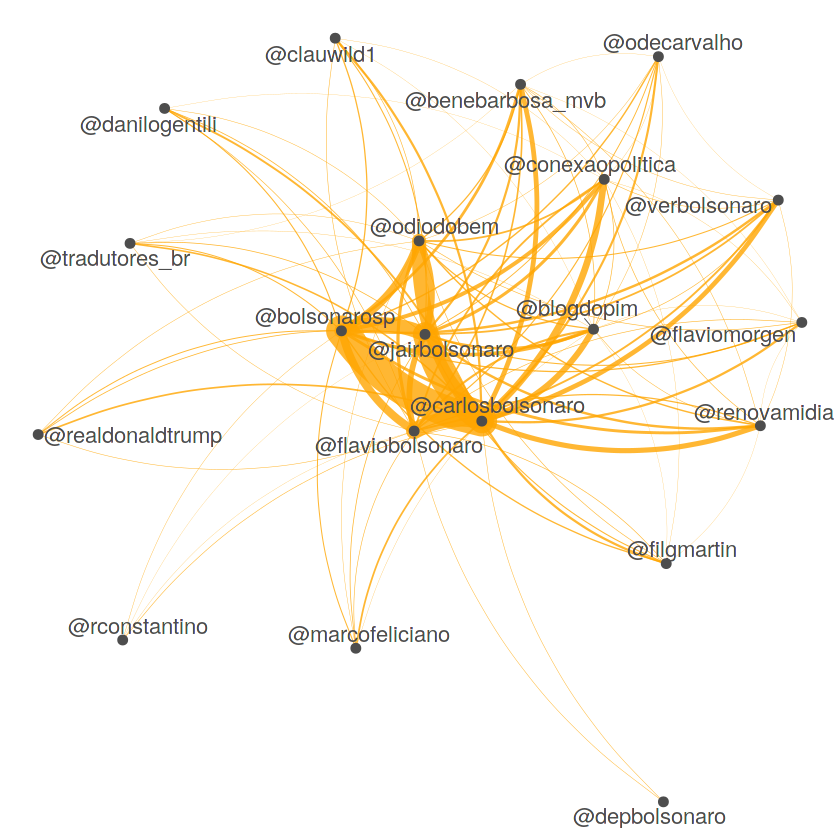

In [7]:
# NETWORK ANALYSIS - @USERS
user_dfm <- dfm_select(mcf, pattern = "@*")
topuser <- names(topfeatures(user_dfm, 20))
user_fcm <- fcm(user_dfm)
user_fcm <- fcm_select(user_fcm, pattern = topuser)
textplot_network(user_fcm, min_freq = 0.5, edge_color = "orange", edge_alpha = 0.8, edge_size = 5)


Network analysis identifies the correlation between the top most frequent users in their posts. There is a strong correlation between President **@jairbolsonaro** and his sons **@carlosbolsonaro**, **@flaviobolsonaro** and **@bolsonarosp**. This added to the high frequency presented by these users in the wordcloud (the first result), showing a strong relationship of ideas between them (which is in fact congruent with their current public images) mainly with the high frequency of the term **rt** discussed earlier.
In addition, **@odecarvalho** (scholar shaped by a “right” ideology congruent with that of the current president) is very present in the government's sphere of control today and **@realdonaldtrump** current president of the United States, a country that Bolsonaro has already openly expressed interest in. in compacting economically. Its ideological ideal is also very present through the **@conexaopolitica** and **@renovamidia** users.

### 3 - SENTIMENT ANALYSIS FOR BRAZIL WORD

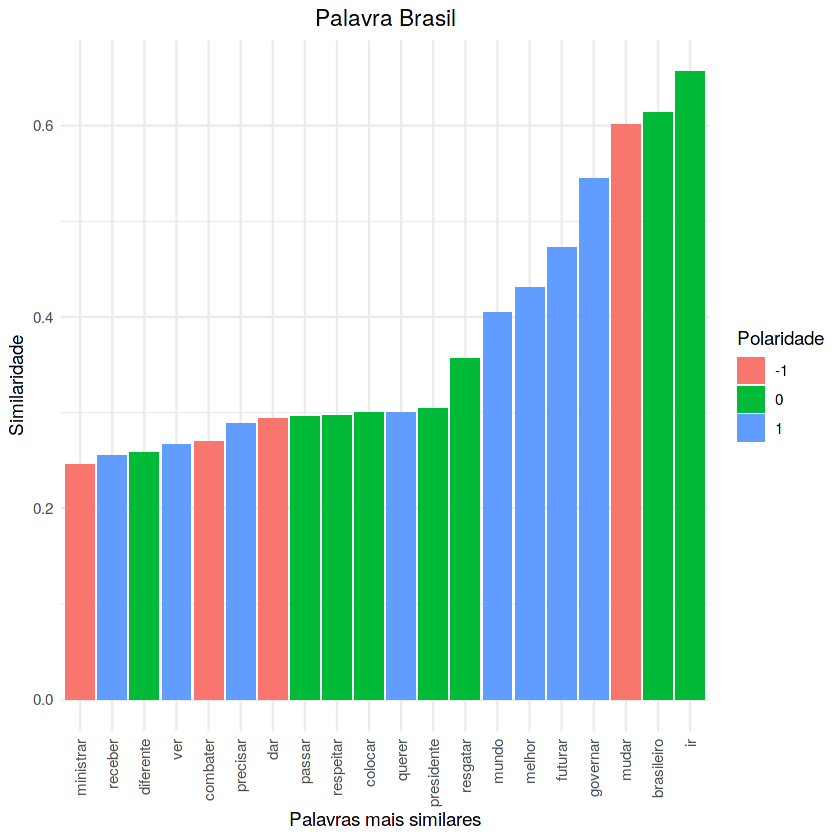

In [8]:
# SIMILATY - BRASIL
sWord1 %>% top_n(20, abs(similarity)) %>% 
  ggplot(aes(x = reorder(token, similarity), y = similarity, fill = as.factor(polarity))) +
  labs(title = 'Palavra Brasil',fill = "Polaridade", y = "Similaridade", x = "Palavras mais similares") + geom_col() + theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), axis.ticks.x = element_blank(), plot.title = element_text(hjust = 0.5))

Regarding the term Brasil, a negative feeling is presented presented by the words **mudança(change)**, **combater(combat)** and **ministrar(minister)** sentiment which may be related to its disapproval of the national political group running the country during the period of its publications. This is reinforced by the large presence of positive sentiments presented by the words **mundo(world)**, **melhor(better)**, **futurar(future)**, **querer(want)**, **precisar(need)** and **governar(rule)** expressing their willingness to change this scenario through a presidential mandate. Neutral terms such as **president(president)** and **Brazil** further strengthen the central idea of disgust for the country's scenario in the period and a search for change through its election victory.



## PHASE 4: NOTES
- The quanteda package is a very good package for R and have a good tutorial, [check here](https://tutorials.quanteda.io/introduction/)
- As a first work on NPL, I notice that the most difficult part is cleaning, most because the order matter. For example, if you take out the punctuation probably a lot of links that contains *https//:* will pass so becareful.

**DISCLAIMER:** The intend from this analysis is to better understand the NPL tools that we have and I'm definitely ** not taking any political side**.